In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Define the list of gun-related words
gun_related_words = ['gun', '2nd amendment', 'second amendment', 'ar-15', 'assault rifle', 'pistols', 'shooting', 'mass shooting', 'school shooting', 'march for our lives']

# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return 0
    for word in word_list:
        if word.lower() in text.lower():  # Case insensitive match
            return 1
    return 0

# Load the CSV file into a pandas DataFrame
file_path = 'Data/fbpac-ads-en-US.csv' 
data = pd.read_csv(file_path)

# Create the new column 'dummy_label'
data['dummy_label'] = data['message'].apply(lambda x: contains_word(x, gun_related_words))

# Calculate number of documents
num_documents = len(data)

# Calculate average document length (in terms of words)
data['word_count'] = data['message'].apply(lambda x: len(str(x).split()))
average_doc_length = data['word_count'].mean()

# Distribution of document lengths
doc_length_distribution = data['word_count'].describe()

# Balance of the dataset
label_distribution = data['dummy_label'].value_counts(normalize=True)

print("Number of Documents:", num_documents)
print("Average Document Length (in words):", average_doc_length)
print("\nDistribution of Document Lengths:")
print(doc_length_distribution)
print("\nBalance of the Dataset:")
print(label_distribution)

# Filter documents related to gun legislation
gun_legislation_messages = [data['message'][i] for i, label in enumerate(data['dummy_label']) if label == 1]

# Custom function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert ENGLISH_STOP_WORDS to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Create TF-IDF vectorizer with text cleaning and stop words removal
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(gun_legislation_messages)

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across documents
word_scores = tfidf_matrix.sum(axis=0)

# Sort the words by TF-IDF score in descending order
sorted_word_indices = word_scores.argsort()[0, ::-1]

# Display the top words associated with gun legislation
print("\nTop words associated with gun legislation:")
for i in range(10):  # Display top 10 words
    word_index = sorted_word_indices[0, i]
    word = tfidf_feature_names[word_index]
    score = word_scores[0, word_index]
    print(f"{word}: {score}")

# Create CountVectorizer with text cleaning and stop words removal
count_vectorizer = CountVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
X = count_vectorizer.fit_transform(gun_legislation_messages)

# Perform LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # Change n_components as needed
lda.fit(X)

# Display the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_indices = topic.argsort()[:-11:-1]  # Display top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    print(", ".join(top_words))

# Perform sentiment analysis for each message
nltk.download('vader_lexicon')  # Download the lexicon required for sentiment analysis
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each message
sentiments = []
for message in data['message']:
    sentiment_score = sid.polarity_scores(message)
    # Classify sentiment based on compound score
    if sentiment_score['compound'] >= 0.05:
        sentiment = 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiment labels to the DataFrame
data['sentiment'] = sentiments

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(data[['message', 'sentiment']])

Number of Documents: 162324
Average Document Length (in words): 55.08601315886745

Distribution of Document Lengths:
count    162324.000000
mean         55.086013
std         103.500739
min           1.000000
25%          22.000000
50%          36.000000
75%          57.000000
max        2976.000000
Name: word_count, dtype: float64

Balance of the Dataset:
dummy_label
0    0.969931
1    0.030069
Name: proportion, dtype: float64

Top words associated with gun legislation:
gun: 252.01715529231095
violence: 146.5818533647582
congress: 106.64386352856862
help: 102.28887761738146
pp: 99.41823965344206
petition: 99.20606056588856
guns: 94.89266171560892
sign: 92.69737692037701
march: 92.2650326676041
people: 92.15738801844712

Top words for each topic:
Topic 0:
pp, people, day, time, like, right, world, just, help, need
Topic 1:
gun, violence, congress, help, petition, need, background, sign, safety, pp


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arlu/nltk_data...



Sentiment analysis results:
                                                  message sentiment
0       <p>BREAKING: Trump’s Department of the Interio...  Negative
1       <p>The Mueller investigation is over. Special ...  Positive
2       <p>Zimbabwe is reeling from the impact of Cycl...  Negative
3       <p>What more can you do in the final hours of ...  Positive
4       <p>Say it loud, say it proud: Our rights, our ...  Positive
...                                                   ...       ...
162319  <p>Rep. Katko voted for tax breaks for his wea...  Positive
162320  <p>Illinois early voting is open NOW &amp; you...   Neutral
162321  <p>From your favorite peaks to the polling pla...  Positive
162322  <p>Beto just announced he’s running for presid...   Neutral
162323  <p>Claim your FREE ACLU Voter sticker today to...  Positive

[162324 rows x 2 columns]


In [2]:
# Load the dataset containing political text data (e.g., speeches, news articles)
political_data = pd.read_csv('Data/fbpac-ads-en-US.csv')

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')  
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each political text
political_data['sentiment_score'] = political_data['message'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Classify sentiment based on the compound score
political_data['sentiment'] = political_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = political_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("Sentiment Distribution:")
print(sentiment_distribution)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arlu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Distribution:
sentiment
Positive    0.625490
Negative    0.257294
Neutral     0.117216
Name: proportion, dtype: float64


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 513 kB 14.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


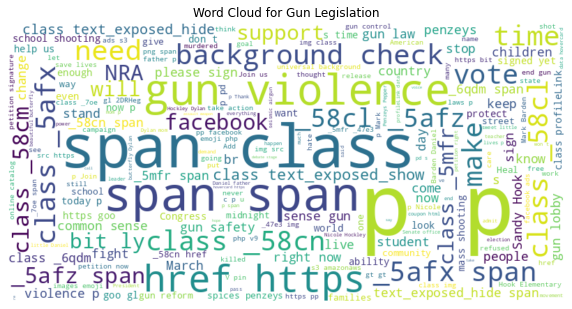

In [4]:
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the text data to include only messages containing gun-related words
gun_legislation_messages = data[data['message'].str.contains('|'.join(gun_related_words), case=False)]['message']

# Concatenate the filtered messages into a single string
text = ' '.join(gun_legislation_messages)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Gun Legislation')
plt.show()


Column names in the dataset:
Index(['id', 'html', 'political', 'not_political', 'title', 'message',
       'thumbnail', 'created_at', 'updated_at', 'lang', 'images',
       'impressions', 'political_probability', 'targeting', 'suppressed',
       'targets', 'advertiser', 'entities', 'page', 'lower_page', 'targetings',
       'paid_for_by', 'targetedness', 'listbuilding_fundraising_proba'],
      dtype='object')
Number of filtered samples: 3883


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f06f286a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f06c1c58ee0>
Traceback 

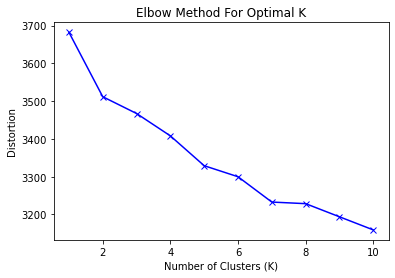

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f06c1b16c10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/tmp/ipykernel_290/1753508802.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

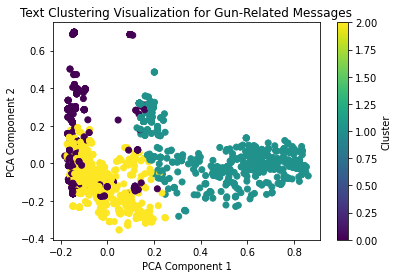

Top terms per cluster:
Cluster 0:
lobby
background
make
help
giffords
gabby
congress
senate
today
daniel

Cluster 1:
span
class
com
https
_58cm
_58cn
_5afx
_58cl
_5afz
dylan

Cluster 2:
violence
nra
march
lives
congress
laws
action
people
safety
sense



In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re


# Define the list of gun-related words
gun_related_words = ['gun', '2nd amendment', 'second amendment', 'ar-15', 'assault rifle', 'pistols', 'shooting', 'mass shooting', 'school shooting', 'march for our lives']

# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return False
    for word in word_list:
        if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE):
            return True
    return False

# Load the dataset containing text data
# Replace 'your_data.csv' with the path to your dataset
data = pd.read_csv('Data/fbpac-ads-en-US.csv')

# Check and print the column names to verify the correct column name for text data
print("Column names in the dataset:")
print(data.columns)

# Replace 'text' with the actual column name that contains the text data
text_column = 'message'  # Change this to the correct column name

# Filter the dataset to include only messages containing gun-related words
filtered_data = data[data[text_column].apply(lambda x: contains_word(x, gun_related_words))]

# Print the number of filtered samples
num_samples = len(filtered_data)
print(f"Number of filtered samples: {num_samples}")

# Ensure there are enough samples for clustering
if num_samples < 2:
    raise ValueError("Not enough samples for clustering. Please ensure the dataset has enough data points.")

# Preprocess the text data (e.g., cleaning, tokenization) - already done by TF-IDF vectorizer

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data[text_column])

# Perform dimensionality reduction for visualization
pca = PCA(n_components=2)
tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# Determine the optimal number of clusters (K) using the elbow method
distortions = []
K = range(1, min(11, num_samples + 1))  # Ensure K is not more than the number of samples
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()

# Choose the optimal number of clusters based on the elbow curve (e.g., K=3, K=4)
# Perform K-means clustering
num_clusters = min(3, num_samples)  # Change this value based on the elbow curve analysis and number of samples
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Add cluster labels to the DataFrame
filtered_data['cluster'] = kmeans.labels_

# Visualize clusters in 2D space
plt.scatter(tfidf_matrix_pca[:, 0], tfidf_matrix_pca[:, 1], c=filtered_data['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Text Clustering Visualization for Gun-Related Messages')
plt.colorbar(label='Cluster')
plt.show()

# Print the top terms per cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}")
    print()